In [1]:
import gc
from itertools import combinations
import pathlib
from typing import Any, Dict, List
import warnings
import yaml

from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

gc.enable()
pd.set_option('display.max_columns', 200)
warnings.simplefilter('ignore')

In [2]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = pl.from_pandas(df)

    new_features1 = [
        (pl.col('ask_price') - pl.col('bid_price')).alias('feature1'),
        (pl.col('ask_price') - pl.col('reference_price')).alias('feature2'),
        (pl.col('bid_price') - pl.col('reference_price')).alias('feature3'),
        (pl.col('ask_price') - pl.col('wap')).alias('feature4'),
        (pl.col('bid_price') - pl.col('wap')).alias('feature5'),
        (pl.col('far_price') - pl.col('near_price')).alias('feature6'),
        (pl.col('far_price') - pl.col('reference_price')).alias('feature7'),
        (pl.col('near_price') - pl.col('reference_price')).alias('feature8'),
        (pl.col('ask_size') - pl.col('bid_size')).alias('feature9'),
        (pl.col('ask_size') - pl.col('matched_size')).alias('feature10'),
        (pl.col('bid_size') - pl.col('matched_size')).alias('feature11'),
        (pl.col('imbalance_size') - pl.col('matched_size')).alias('feature12'),
        (pl.col('ask_price') + pl.col('bid_price')).alias('feature13'),
        (pl.col('far_price') + pl.col('near_price')).alias('feature14'),
        (pl.col('ask_size') + pl.col('bid_size')).alias('feature15'),

        ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('reference_price') - pl.col('bid_price'))).alias('feature16'), 
        ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('wap') - pl.col('bid_price'))).alias('feature17'), 
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('bid_price') - pl.col('reference_price'))).alias('feature18'), 
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('wap') - pl.col('reference_price'))).alias('feature19'), 
        ((pl.col('ask_price') - pl.col('wap')) / (pl.col('bid_price') - pl.col('wap'))).alias('feature20'), 
        ((pl.col('ask_price') - pl.col('wap')) / (pl.col('reference_price') - pl.col('wap'))).alias('feature21'),
        ((pl.col('bid_price') - pl.col('ask_price')) / (pl.col('reference_price') - pl.col('ask_price'))).alias('feature22'),
        ((pl.col('bid_price') - pl.col('ask_price')) / (pl.col('wap') - pl.col('ask_price'))).alias('feature23'),
        ((pl.col('bid_price') - pl.col('reference_price')) / (pl.col('wap') - pl.col('reference_price'))).alias('feature24'),
        ((pl.col('bid_price') - pl.col('wap')) / (pl.col('reference_price') - pl.col('wap'))).alias('feature25'),
        ((pl.col('reference_price') - pl.col('ask_price')) / (pl.col('wap') - pl.col('ask_price'))).alias('feature26'),
        ((pl.col('reference_price') - pl.col('bid_price')) / (pl.col('wap') - pl.col('bid_price'))).alias('feature27'),

        ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('matched_size') - pl.col('bid_size'))).alias('feature28'), 
        ((pl.col('ask_size') - pl.col('matched_size')) / (pl.col('bid_size') - pl.col('matched_size'))).alias('feature29'), 
        ((pl.col('bid_size') - pl.col('ask_size')) / (pl.col('matched_size') - pl.col('ask_size'))).alias('feature30'),

        (pl.col('bid_price') / pl.col('ask_price')).alias('feature31'),
        (pl.col('reference_price') / pl.col('ask_price')).alias('feature32'),
        (pl.col('wap') / pl.col('ask_price')).alias('feature33'),
        (pl.col('reference_price') / pl.col('bid_price')).alias('feature34'),
        (pl.col('wap') / pl.col('bid_price')).alias('feature35'),

        (pl.col('bid_size') / pl.col('ask_size')).alias('feature36'),
        (pl.col('ask_size') / pl.col('matched_size')).alias('feature37'),
        (pl.col('bid_size') / pl.col('matched_size')).alias('feature38'),
        ((pl.col('ask_price') - pl.col('bid_price')) * ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size')))).alias('feature39'),
    ]

    df = (
        df
        .with_columns(new_features1)
        .to_pandas()
    )
    return df

In [3]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path. joinpath('train.csv'))
train_df.drop(columns=['row_id', 'time_id'], inplace=True)
train_df = train_df.astype(np.float32)
display(train_df)
display(train_df.describe())

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0.0,0.0,0.0,3.180603e+06,1.0,0.999812,13380277.00,NaN,NaN,0.999812,60651.500000,1.000026,8493.030273,1.000000,-3.029704
1,1.0,0.0,0.0,1.666039e+05,-1.0,0.999896,1642214.25,NaN,NaN,0.999896,3233.040039,1.000660,20605.089844,1.000000,-5.519986
2,2.0,0.0,0.0,3.028799e+05,-1.0,0.999561,1819368.00,NaN,NaN,0.999403,37956.000000,1.000298,18995.000000,1.000000,-8.389950
3,3.0,0.0,0.0,1.191768e+07,-1.0,1.000171,18389746.00,NaN,NaN,0.999999,2324.899902,1.000214,479032.406250,1.000000,-4.010201
4,4.0,0.0,0.0,4.475500e+05,-1.0,0.999532,17860614.00,NaN,NaN,0.999394,16485.539062,1.000016,434.100006,1.000000,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195.0,480.0,540.0,2.440723e+06,-1.0,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.039062,1.000434,319862.406250,1.000328,2.310276
5237976,196.0,480.0,540.0,3.495105e+05,-1.0,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.406250,1.000900,93393.070312,1.000819,-8.220077
5237977,197.0,480.0,540.0,0.000000e+00,0.0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.660156,0.995883,180038.312500,0.995797,1.169443
5237978,198.0,480.0,540.0,1.000899e+06,1.0,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.718750,0.999210,669893.000000,0.999008,-1.540184


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06
mean,9.928867e+01,2.415100e+02,2.699999e+02,5.715294e+06,-1.189619e-02,9.999961e-01,4.510024e+07,1.001713e+00,9.996603e-01,9.997261e-01,5.181356e+04,1.000264e+00,5.357570e+04,9.999929e-01,-4.756123e-02
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279576e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02


,target_imbalance_size_mean,target_imbalance_size_std,target_reference_price_mean,target_reference_price_std,target_matched_size_mean,target_matched_size_std,target_far_price_mean,target_far_price_std,target_near_price_mean,target_near_price_std,target_bid_price_mean,target_bid_price_std,target_bid_size_mean,target_bid_size_std,target_ask_price_mean,target_ask_price_std,target_ask_size_mean,target_ask_size_std,target_wap_mean,target_wap_std
count,9.523200e+04,9.523200e+04,95232.000000,95232.000000,9.523200e+04,9.523200e+04,95212.000000,95210.000000,95232.000000,95232.000000,95232.000000,95232.000000,9.523600e+04,9.523600e+04,95232.000000,95232.000000,9.523600e+04,9.523600e+04,95232.000000,95232.000000
mean,5.715293e+06,3.992132e+06,0.999996,0.001164,4.510024e+07,1.045875e+07,1.002956,0.014600,0.999660,0.003727,0.999726,0.001145,5.181359e+04,5.054482e+04,1.000265,0.001147,5.357568e+04,5.388874e+04,0.999992,0.001155
std,1.658712e+07,1.151245e+07,0.002118,0.000781,1.376175e+08,2.278732e+07,0.425573,0.865223,0.010284,0.005496,0.002093,0.000768,6.443682e+04,7.655692e+04,0.002105,0.000766,6.522226e+04,9.902588e+04,0.002087,0.000764
min,0.000000e+00,0.000000e+00,0.973249,0.000000,3.216563e+04,5.832037e+03,0.715920,0.000000,0.910535,0.000000,0.971857,0.000000,0.000000e+00,0.000000e+00,0.974224,0.000000,0.000000e+00,0.000000e+00,0.973152,0.000037
25%,5.238618e+05,4.711496e+05,0.998833,0.000656,6.058991e+06,2.150703e+06,0.994292,0.000684,0.996434,0.000577,0.998601,0.000645,2.015109e+04,2.097927e+04,0.999091,0.000648,2.108929e+04,2.157596e+04,0.998846,0.000657
50%,1.644225e+06,1.214866e+06,0.999954,0.000968,1.361294e+07,4.479579e+06,0.999845,0.003017,0.999859,0.001439,0.999727,0.000951,3.110650e+04,3.354866e+04,1.000181,0.000956,3.259076e+04,3.470452e+04,0.999951,0.000963
75%,4.729748e+06,3.210427e+06,1.001102,0.001449,3.219260e+07,9.718649e+06,1.005149,0.008979,1.003097,0.004686,1.000843,0.001426,5.450567e+04,5.756313e+04,1.001338,0.001429,5.689091e+04,5.971658e+04,1.001084,0.001435
max,1.432570e+09,1.172478e+09,1.044313,0.021726,7.192703e+09,1.780157e+09,103.692535,158.887177,1.155919,0.094262,1.038383,0.021644,2.800104e+06,6.304447e+06,1.044632,0.021289,2.621130e+06,1.001047e+07,1.040546,0.021464


20


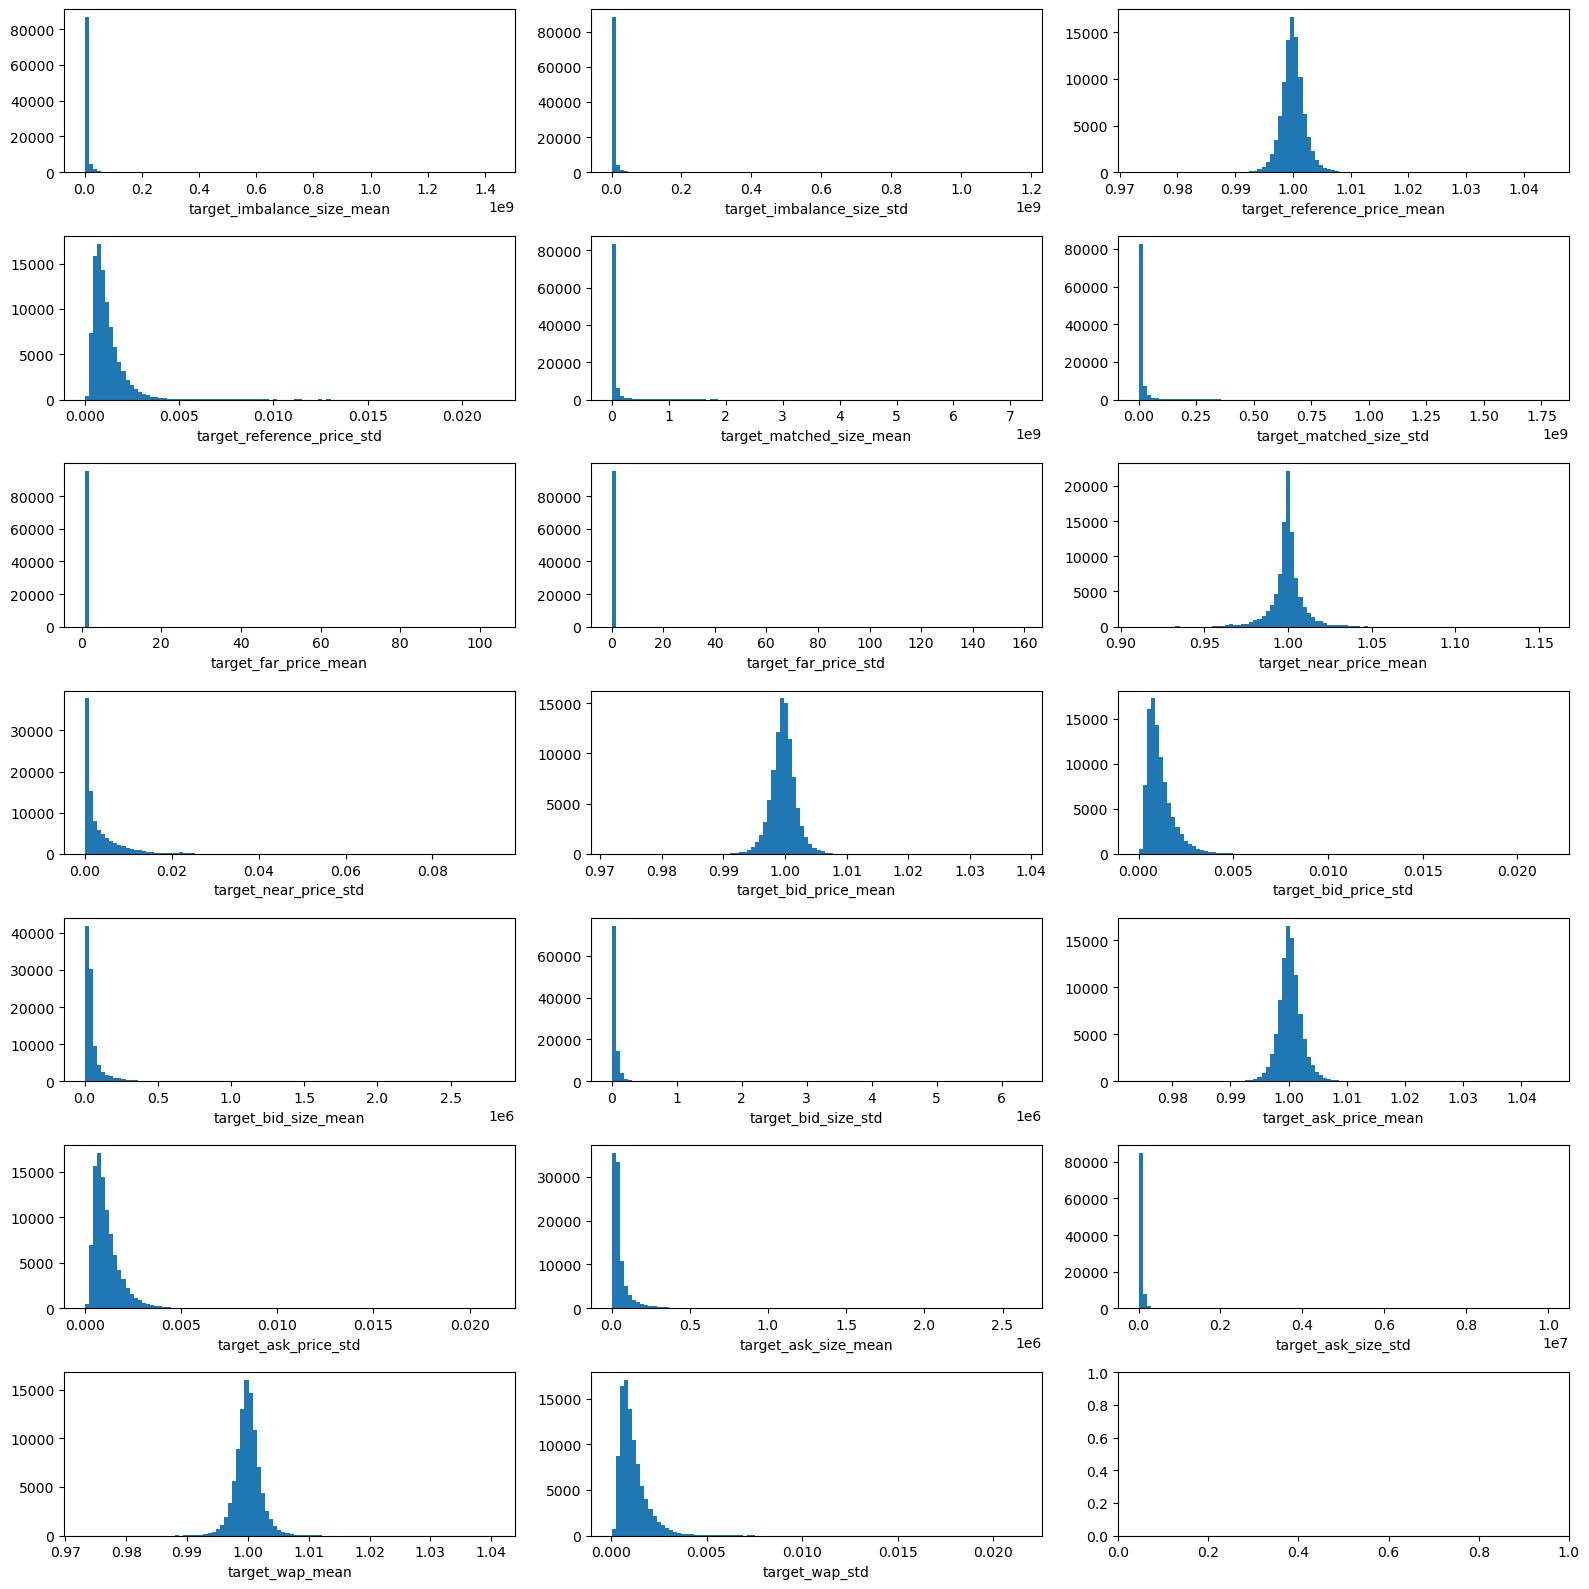

target_imbalance_size_mean  target_imbalance_size_std  \
stock_id date_id                                                          
0.0      0.0                    1.229794e+06               1.516172e+06   
         1.0                    1.175555e+06               5.772946e+05   
         2.0                    1.593084e+04               9.749596e+04   
         3.0                    5.396968e+06               1.799225e+06   
         4.0                    4.132774e+06               8.552621e+05   

                  target_reference_price_mean  target_reference_price_std  \
stock_id date_id                                                            
0.0      0.0                         0.999664                    0.000435   
         1.0                         0.999050                    0.000391   
         2.0                         0.998940                    0.000498   
         3.0                         0.998883                    0.000741   
         4.0                         1.000689                    0.000901   

                  target_matched_size_mean  target_matched_size_std  \
stock_id date_id                                                      
0.0      0.0                    20649132.0             5.655094e+06   
         1.0                     9342939.0             2.878321e+06   
         2.0                    13069748.0             2.882195e+06   
         3.0                    14145322.0             5.780270e+06   
         4.0                    18829828.0             7.863443e+06   

                  target_far_price_mean  target_far_price_std  \
stock_id date_id                                                
0.0      0.0                   0.999692              0.000521   
         1.0                   1.009668              0.006552   
         2.0                   0.998583              0.000233   
         3.0                   0.977043              0.027838   
         4.0                   0.985712              0.007217   

                  target_near_price_mean  target_near_price_std  \
stock_id date_id                                                  
0.0      0.0                    0.999615               0.000448   
         1.0                    1.003035               0.002445   
         2.0                    0.998583               0.000233   
         3.0                    0.938763               0.038452   
         4.0                    0.986791               0.007209   

                  target_bid_price_mean  target_bid_price_std  \
stock_id date_id                                                
0.0      0.0                   0.999547              0.000430   
         1.0                   0.998903              0.000387   
         2.0                   0.998895              0.000509   
         3.0                   0.998834              0.000763   
         4.0                   1.000637              0.000900   

                  target_bid_size_mean  target_bid_size_std  \
stock_id date_id                                              
0.0      0.0              36503.148438         31260.274132   
         1.0              39277.046875         63803.089041   
         2.0              34400.523438         23986.836537   
         3.0              45016.867188         34792.442674   
         4.0              31768.835938         31265.154926   

                  target_ask_price_mean  target_ask_price_std  \
stock_id date_id                                                
0.0      0.0                   0.999697              0.000457   
         1.0                   0.999091              0.000467   
         2.0                   0.999039              0.000511   
         3.0                   0.999015              0.000753   
         4.0                   1.000925              0.000965   

                  target_ask_size_mean  target_ask_size_std  target_wap_mean  \
stock_id date_id                                                               
0.0      0.0  

target_imbalance_size_mean  target_imbalance_size_std  \
stock_id date_id                                                          
0.0      0.0                       14.022358                  28.047210   
         1.0                       13.977252                  27.081619   
         2.0                        9.676075                  25.303077   
         3.0                       15.501348                  28.218377   
         4.0                       15.234460                  27.474674   

                  target_reference_price_mean  target_reference_price_std  \
stock_id date_id                                                            
0.0      0.0                         0.692979                    6.078273   
         1.0                         0.692672                    5.970583   
         2.0                         0.692617                    6.211764   
         3.0                         0.692589                    6.609187   
         4.0                         0.693492                    6.804755   

                  target_matched_size_mean  target_matched_size_std  \
stock_id date_id                                                      
0.0      0.0                     16.843184                29.363578   
         1.0                     16.050131                28.688228   
         2.0                     16.385811                28.689573   
         3.0                     16.464895                29.385471   
         4.0                     16.750954                29.693246   

                  target_far_price_mean  target_far_price_std  \
stock_id date_id                                                
0.0      0.0                   0.692993              6.257366   
         1.0                   0.697969              8.787727   
         2.0                   0.692439              5.454497   
         3.0                   0.681602             10.234209   
         4.0                   0.685977              8.884350   

                  target_near_price_mean  target_near_price_std  \
stock_id date_id                                                  
0.0      0.0                    0.692955               6.106844   
         1.0                    0.694664               7.802283   
         2.0                    0.692439               5.454497   
         3.0                    0.662050              10.557204   
         4.0                    0.686521               8.883268   

                  target_bid_price_mean  target_bid_price_std  \
stock_id date_id                                                
0.0      0.0                   0.692921              6.065131   
         1.0                   0.692599              5.962000   
         2.0                   0.692594              6.234771   
         3.0                   0.692564              6.639210   
         4.0                   0.693466              6.803568   

                  target_bid_size_mean  target_bid_size_std  \
stock_id date_id                                              
0.0      0.0                 10.505181            24.165614   
         1.0                 10.578421            24.879067   
         2.0                 10.445856            23.900771   
         3.0                 10.714815            24.272666   
         4.0                 10.366273            24.165770   

                  target_ask_price_mean  target_ask_price_std  \
stock_id date_id                                                
0.0      0.0                   0.692996              6.126606   
         1.0                   0.692693              6.148734   
         2.0                   0.692666              6.238996   
         3.0                   0.692655              6.625522   
         4.0                   0.693610              6.873087   

                  target_ask_size_mean  target_ask_size_std  target_wap_mean  \
stock_id date_id                                                               
0.0      0.0  

20


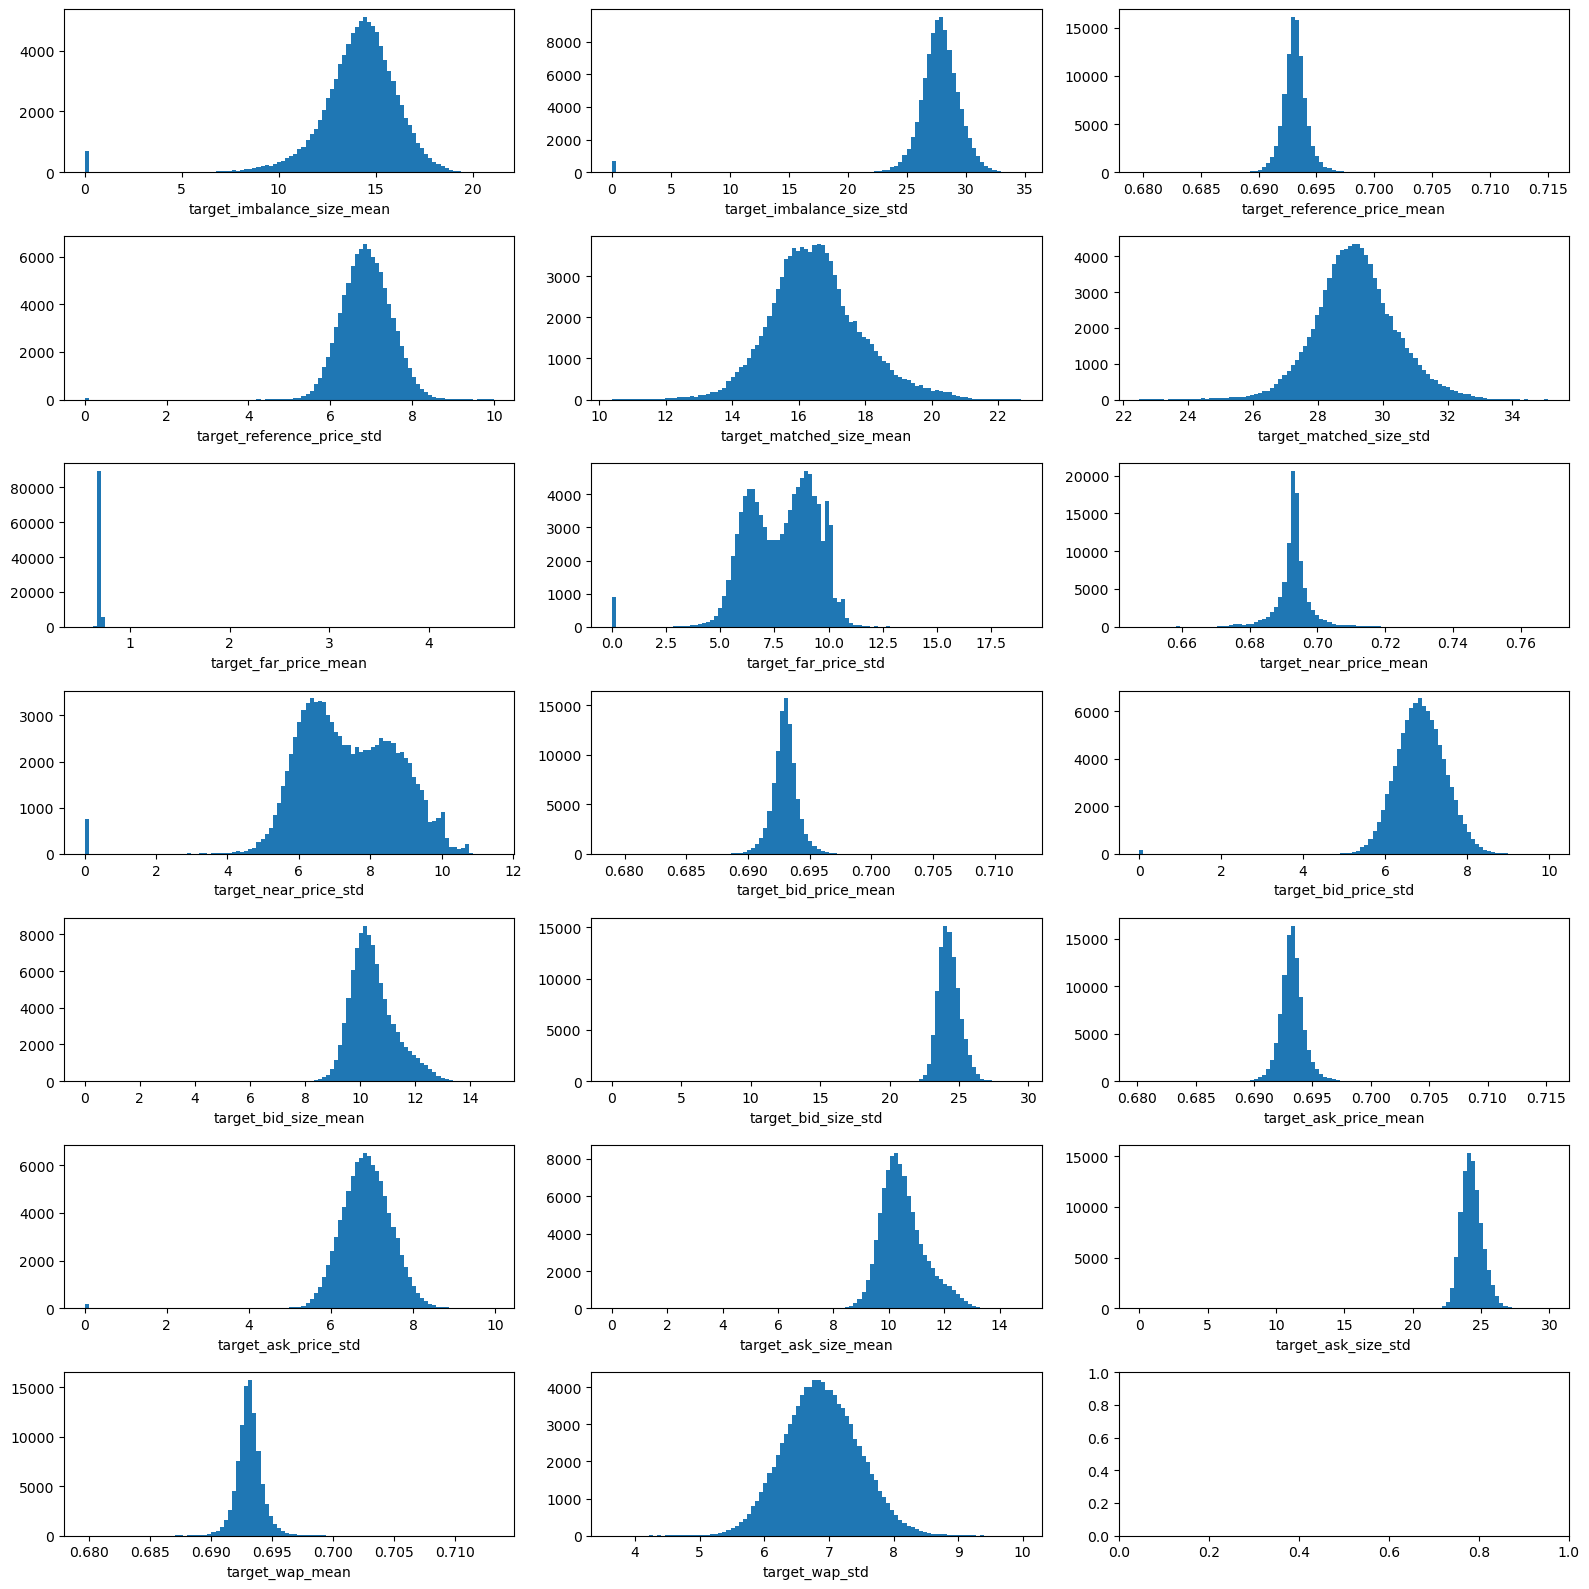

In [4]:
except_features = [
    'seconds_in_bucket',
    'imbalance_buy_sell_flag',
    'date_id',
    'stock_id',
    'target',
]

agg_features = [col for col in train_df.columns if col not in except_features]
statistics_per_date = train_df.groupby(['stock_id', 'date_id'])[agg_features].agg(['mean', 'std'])
statistics_per_date.columns = ['target_'+'_'.join(col) for col in statistics_per_date.columns]
display(statistics_per_date.describe())

target_columns = [col for col in statistics_per_date.columns if 'target' in col]
num_targets = len(target_columns)
print(num_targets)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    axs[i//3, i%3].hist(statistics_per_date[target_columns[i]], bins=100)
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

display(statistics_per_date.head())
for col in statistics_per_date.columns:
    if 'mean' in col:
        statistics_per_date[col] = np.log1p(statistics_per_date[col])
    elif 'std' in col:
        statistics_per_date[col] = np.log1p(1e+06 * statistics_per_date[col])
display(statistics_per_date.head())

target_columns = [col for col in statistics_per_date.columns if 'target' in col]
num_targets = len(target_columns)
print(num_targets)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    axs[i//3, i%3].hist(statistics_per_date[target_columns[i]], bins=100)
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

In [5]:
train_df = preprocess(train_df)
train_df = train_df.groupby(['stock_id', 'date_id']).first().drop(columns=['target', 'seconds_in_bucket'])

train_df = train_df.merge(statistics_per_date, on=['stock_id', 'date_id']).reset_index()
train_df.dropna(inplace=True)
display(train_df)

del statistics_per_date
gc.collect()

,stock_id,date_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,target_imbalance_size_mean,target_imbalance_size_std,target_reference_price_mean,target_reference_price_std,target_matched_size_mean,target_matched_size_std,target_far_price_mean,target_far_price_std,target_near_price_mean,target_near_price_std,target_bid_price_mean,target_bid_price_std,target_bid_size_mean,target_bid_size_std,target_ask_price_mean,target_ask_price_std,target_ask_size_mean,target_ask_size_std,target_wap_mean,target_wap_std
0,0.0,0.0,3180602.750,1.0,0.999812,13380277.0,1.000241,1.000241,0.999812,60651.500000,1.000026,8493.030273,1.0,0.000214,0.000214,0.000000,0.000026,-0.000188,0.000000,0.000000,0.000000,-52158.468750,-13371784.0,-13319626.0,-10199674.00,1.999838,2.000482,69144.531250,inf,1.138237,inf,1.138237,-0.138237,-0.138237,1.000000,8.233945,0.000000,1.000000,8.233945,0.000000,-0.003916,1.003916,0.003901,0.999786,0.999786,0.999974,1.000000,1.000188,7.141326,0.000635,0.004533,-0.000161,14.022358,28.047210,0.692979,6.078273,16.843184,29.363578,0.692993,6.257366,0.692955,6.106844,0.692921,6.065131,10.505181,24.165614,0.692996,6.126606,10.437327,23.922253,0.692956,6.089807
1,0.0,1.0,1870169.375,1.0,0.999923,5132566.5,1.018514,1.010132,0.999601,9302.000000,1.000998,23287.500000,1.0,0.001397,0.001075,-0.000322,0.000998,-0.000399,0.008382,0.018913,0.010531,13985.500000,-5109279.0,-5123264.5,-3262397.00,2.000599,2.028646,32589.500000,4.338763,3.501344,-3.338763,13.959752,-2.501344,-12.959752,1.299512,1.399785,-4.181115,5.181115,1.077162,0.806991,0.002730,0.997270,-0.002737,0.998604,0.998926,0.999003,1.000322,1.000399,0.399442,0.004537,0.001812,0.000600,13.977252,27.081619,0.692672,5.970583,16.050131,28.688228,0.697969,8.787727,0.694664,7.802283,0.692599,5.962000,10.578421,24.879067,0.692693,6.148734,10.142269,23.950888,0.692647,6.032526
2,0.0,2.0,0.000,0.0,0.999968,9704431.0,0.998774,0.998774,0.999968,4055.479980,1.000185,23231.880859,1.0,0.000217,0.000217,0.000000,0.000185,-0.000032,0.000000,0.000000,0.000000,19176.400391,-9681199.0,-9700376.0,-9704431.00,2.000153,1.997548,27287.361328,inf,6.780261,inf,6.780261,-5.780261,-5.780261,1.000000,1.173003,0.000000,1.000000,1.173003,0.000000,0.001977,0.998023,-0.001981,0.999783,0.999783,0.999815,1.000000,1.000032,0.174565,0.002394,0.000418,0.000153,9.676075,25.303077,0.692617,6.211764,16.385811,28.689573,0.692439,5.454497,0.692439,5.454497,0.692594,6.234771,10.445856,23.900771,0.692666,6.238996,10.542827,24.072901,0.692628,6.233563
3,0.0,3.0,3993793.750,-1.0,1.000232,8122459.5,0.908138,0.908138,0.999907,9218.000000,1.000341,33752.519531,1.0,0.000434,0.000109,-0.000325,0.000341,-0.000093,-0.050983,-0.089708,-0.090684,24534.519531,-8088707.0,-8113241.5,-4128665.75,2.000248,1.867259,42970.519531,1.335657,4.667949,-0.335657,-0.470195,-3.667949,1.470195,3.979235,1.272632,1.400822,-0.400822,0.319818,3.494872,0.003024,0.996976,-0.003033,0.999566,0.999891,0.999659,1.000325,1.000093,0.273106,0.004155,0.001135,0.000248,15.501348,28.218377,0.692589,6.609187,16.464895,29.385471,0.681602,10.234209,0.662050,10.557204,0.692564,6.639210,10.714815,24.272666,0.692655,6.625522,11.230031,25.744762,0.692607,6.640256
4,0.0,4.0,4529594.000,-1.0,1.000232,10151651.0,0.980448,0.980551,0.999923,46870.320312,1.000335,204062.156250,1.0,0.000412,0.000103,-0.000309,0.000335,-0.000077,-0.000103,-0.019887,-0.019784,157191.843750,-9947589.0,-10104781.0,-5622057.00,2.000258,1.960999,250932.468750,1.333333,5.349845,-0.333333,-0.443988,-4.349845,1.443988,4.000000,1.229893,1.331963,-0.33

25

## train catboost models using cross validation

In [6]:
def train(
        dataset: pd.DataFrame,
        model_params: Dict[str, Any],
        outputs_dir: pathlib.Path,
    ):
    
    target_columns = [col for col in dataset.columns if 'target' in col]
    print(target_columns)
    feature_columns = [col for col in dataset.columns if col not in target_columns and col != 'date_id']
    days= np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    fimps = []
    result_pred = np.zeros((11990, 20))
    result_true = np.zeros((11990, 20))

    history = {
        'train_mae': [],
        'valid_mae': [],
    }

    mean_num_iteration = 0

    step = 60
    valid_days = days[-step:]
    valid_X = dataset.query('date_id in @valid_days')[feature_columns]
    valid_y = dataset.query('date_id in @valid_days')[target_columns]

    train_day_lower_limits = np.arange(0, 480-step, step)

    for k, lower_limit in enumerate(train_day_lower_limits):
        train_days = np.arange(lower_limit, lower_limit+step)
        print(f'fold {k+1}')
        print(train_days)
        print(valid_days)
        
        plot_time(days, train_days, valid_days)
        
        train_X = dataset.query('date_id in @train_days')[feature_columns]
        train_y = dataset.query('date_id in @train_days')[target_columns]
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')
        
        train_pool = Pool(data=train_X, label=train_y)
        valid_pool = Pool(data=valid_X, label=valid_y)
        
        model = CatBoostRegressor(**model_params)
        model.fit(
            X=train_pool,
            eval_set=[(valid_pool)],
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=500,
        )
        model.save_model(
            outputs_dir.joinpath(f'catboost_fold{k+1}_predict_statistics.txt'),
        )
        
        fimp = model.get_feature_importance(valid_pool, type='PredictionValuesChange')
        fimp = pd.DataFrame(fimp, index=feature_columns, columns=[f'fold{k+1}'])
        fimps.append(fimp)

        train_pred = model.predict(train_X)
        valid_pred = model.predict(valid_X)
        
        result_pred += valid_pred
        result_true += valid_y.values

        history['train_mae'].append(np.mean(abs(train_y.values - train_pred), axis=0))
        history['valid_mae'].append(np.mean(abs(valid_y.values - valid_pred), axis=0))

        mean_num_iteration += model.get_best_iteration()

        del train_X, train_y, train_pool, valid_pool, model, fimp
        del train_pred, valid_pred
        gc.collect()

    del valid_X, valid_y
    gc.collect()

    history = pd.DataFrame.from_dict(history)
    mean_num_iteration = int(mean_num_iteration / len(train_day_lower_limits))

    result_pred /= len(train_day_lower_limits)
    result_true /= len(train_day_lower_limits)
    
    fimps = pd.concat(fimps, axis=1)
    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    fimps.index = [f'{len(fimps)-i}_{idx}' for i, idx in enumerate(fimps.index)]
    
    return history, result_pred, result_true, fimps, mean_num_iteration


def plot_time(all_time, train_time, valid_time):
    _, ax = plt.subplots()
    ax.barh(y='all', height=0.6, width=len(all_time), left=0, color='tab:blue')
    ax.barh(y='train+valid+test', height=0.6, width=[len(train_time), len(valid_time)],
            left=[train_time.min(), valid_time.min()], color=['tab:orange', 'tab:green', 'tab:red'])
    xcenter = [len(all_time)//2, train_time.min()+len(train_time)//2,
               valid_time.min()+len(valid_time)//2]
    ycenter = [0, 1, 1, 1]
    width = [f'all\n{len(all_time)}', f'train\n{len(train_time)}', f'valid\n{len(valid_time)}']
    for x, y, w in zip(xcenter, ycenter, width):
        ax.text(x, y, str(w),  ha='center', va='center')
    ax.set_xticks([train_time.min(), train_time.max(), valid_time.min(), len(all_time)])
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

['target_imbalance_size_mean', 'target_imbalance_size_std', 'target_reference_price_mean', 'target_reference_price_std', 'target_matched_size_mean', 'target_matched_size_std', 'target_far_price_mean', 'target_far_price_std', 'target_near_price_mean', 'target_near_price_std', 'target_bid_price_mean', 'target_bid_price_std', 'target_bid_size_mean', 'target_bid_size_std', 'target_ask_price_mean', 'target_ask_price_std', 'target_ask_size_mean', 'target_ask_size_std', 'target_wap_mean', 'target_wap_std']
fold 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
[420. 421. 422. 423. 424. 425. 426. 427. 428. 429. 430. 431. 432. 433.
 434. 435. 436. 437. 438. 439. 440. 441. 442. 443. 444. 445. 446. 447.
 448. 449. 450. 451. 452. 453. 454. 455. 456. 457. 458. 459. 460. 461.
 462. 463. 464. 465. 466. 467. 468. 469. 470. 471. 472. 473. 474. 475.
 476. 477. 478. 479.

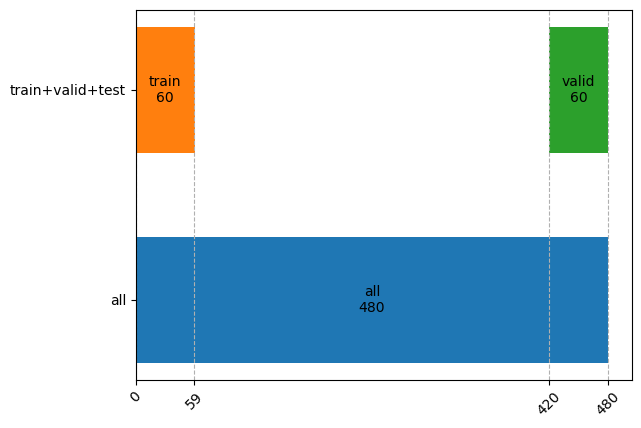

train_X.shape: (11561, 51), train_y.shape: (11561, 20)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 20)
0:	learn: 5.4846366	test: 4.7961250	best: 4.7961250 (0)	total: 408ms	remaining: 33m 58s
500:	learn: 3.3607878	test: 2.9206547	best: 2.9206547 (500)	total: 2m 57s	remaining: 26m 35s
1000:	learn: 2.9855957	test: 2.8275206	best: 2.8275206 (1000)	total: 5m 54s	remaining: 23m 38s
1500:	learn: 2.6919125	test: 2.8142033	best: 2.8142033 (1500)	total: 8m 49s	remaining: 20m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.811751015
bestIteration = 1729

Shrink model to first 1730 iterations.
fold 2
[ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119]
[420. 421. 422. 423. 424. 425. 426. 427. 428. 429. 430. 431. 432. 433.
 434. 435. 436. 437. 438. 439. 440. 441. 442. 443. 444. 

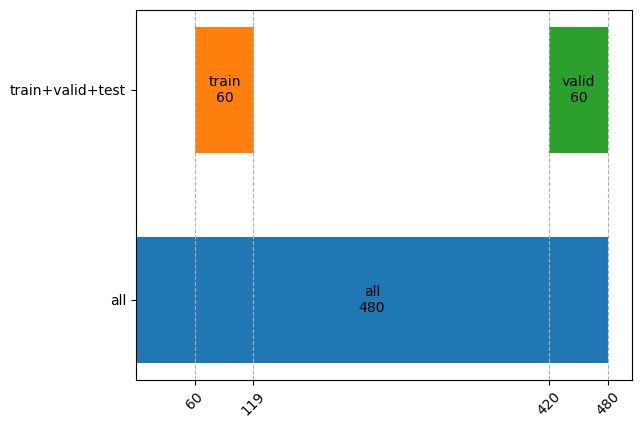

train_X.shape: (11779, 51), train_y.shape: (11779, 20)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 20)
0:	learn: 5.0261641	test: 4.6521901	best: 4.6521901 (0)	total: 331ms	remaining: 27m 35s
500:	learn: 2.9715771	test: 2.9007644	best: 2.9007644 (500)	total: 2m 53s	remaining: 25m 59s
1000:	learn: 2.6089025	test: 2.8221108	best: 2.8221108 (1000)	total: 5m 49s	remaining: 23m 14s
1500:	learn: 2.3564343	test: 2.8060380	best: 2.8060033 (1488)	total: 8m 43s	remaining: 20m 20s
2000:	learn: 2.1477843	test: 2.7982885	best: 2.7981084 (1996)	total: 11m 38s	remaining: 17m 27s
2500:	learn: 1.9667463	test: 2.7928214	best: 2.7926172 (2470)	total: 14m 30s	remaining: 14m 30s
3000:	learn: 1.8026286	test: 2.7893725	best: 2.7893486 (2982)	total: 17m 23s	remaining: 11m 34s
3500:	learn: 1.6658542	test: 2.7863930	best: 2.7863930 (3500)	total: 20m 14s	remaining: 8m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.784726995
bestIteration = 3803

Shrink model to first 3804 iteratio

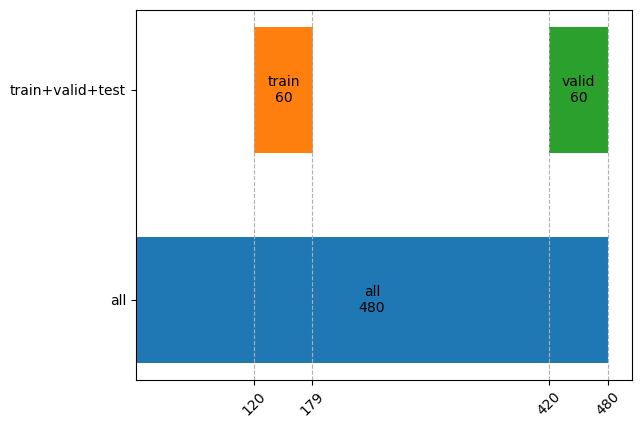

train_X.shape: (11818, 51), train_y.shape: (11818, 20)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 20)
0:	learn: 5.2043897	test: 4.7092519	best: 4.7092519 (0)	total: 319ms	remaining: 26m 34s
500:	learn: 3.0168337	test: 2.9747028	best: 2.9747028 (500)	total: 2m 55s	remaining: 26m 12s
1000:	learn: 2.6252448	test: 2.8917582	best: 2.8917582 (1000)	total: 5m 49s	remaining: 23m 16s
1500:	learn: 2.3548426	test: 2.8766961	best: 2.8766961 (1500)	total: 8m 43s	remaining: 20m 21s
2000:	learn: 2.1254825	test: 2.8715717	best: 2.8714919 (1997)	total: 11m 39s	remaining: 17m 28s
2500:	learn: 1.9231806	test: 2.8655894	best: 2.8654938 (2486)	total: 14m 36s	remaining: 14m 35s
3000:	learn: 1.7596308	test: 2.8596258	best: 2.8596258 (3000)	total: 17m 33s	remaining: 11m 41s
3500:	learn: 1.6214482	test: 2.8550717	best: 2.8550717 (3500)	total: 20m 27s	remaining: 8m 45s
4000:	learn: 1.5012895	test: 2.8512139	best: 2.8511389 (3997)	total: 23m 21s	remaining: 5m 50s
4500:	learn: 1.3989280	test: 2.8478667	be

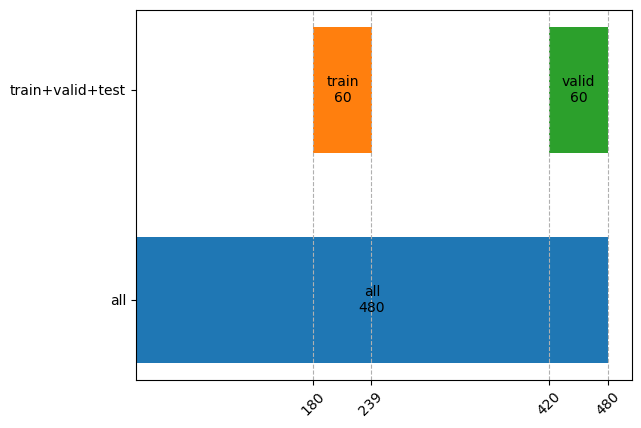

train_X.shape: (11925, 51), train_y.shape: (11925, 20)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 20)
0:	learn: 5.2467240	test: 4.7509977	best: 4.7509977 (0)	total: 353ms	remaining: 29m 25s
500:	learn: 3.1315526	test: 2.9634434	best: 2.9634434 (500)	total: 2m 58s	remaining: 26m 40s
1000:	learn: 2.7337402	test: 2.8653037	best: 2.8653037 (1000)	total: 5m 51s	remaining: 23m 25s
1500:	learn: 2.4415886	test: 2.8463804	best: 2.8463804 (1500)	total: 8m 47s	remaining: 20m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.843047358
bestIteration = 1826

Shrink model to first 1827 iterations.
fold 5
[240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299]
[420. 421. 422. 423. 424. 425. 426. 427. 428. 429. 430. 431. 432. 433.
 434. 435. 436. 437. 438. 439. 440. 441. 442. 443. 444. 

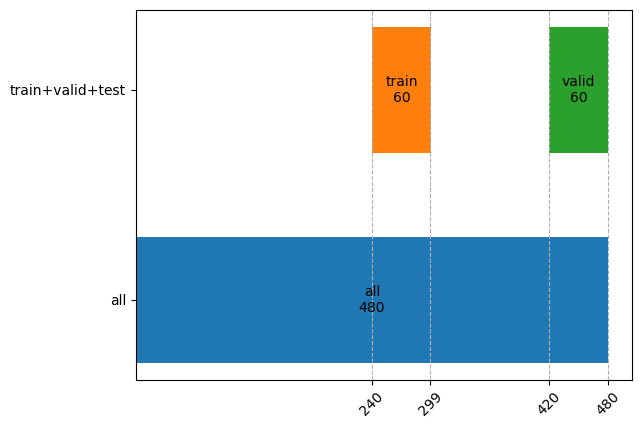

train_X.shape: (11943, 51), train_y.shape: (11943, 20)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 20)
0:	learn: 4.9318690	test: 4.6808839	best: 4.6808839 (0)	total: 324ms	remaining: 27m 1s
500:	learn: 2.8418148	test: 2.8492928	best: 2.8492928 (500)	total: 2m 56s	remaining: 26m 22s
1000:	learn: 2.4952437	test: 2.7445449	best: 2.7445449 (1000)	total: 5m 52s	remaining: 23m 28s
1500:	learn: 2.2480681	test: 2.7258594	best: 2.7258258 (1483)	total: 8m 50s	remaining: 20m 37s
2000:	learn: 2.0351215	test: 2.7201632	best: 2.7200822 (1982)	total: 11m 47s	remaining: 17m 39s
2500:	learn: 1.8619747	test: 2.7132113	best: 2.7132025 (2499)	total: 14m 41s	remaining: 14m 41s
3000:	learn: 1.7124406	test: 2.7076741	best: 2.7076454 (2994)	total: 17m 36s	remaining: 11m 44s
3500:	learn: 1.5858020	test: 2.7042435	best: 2.7042435 (3500)	total: 20m 32s	remaining: 8m 47s
4000:	learn: 1.4731111	test: 2.7015722	best: 2.7015722 (4000)	total: 23m 29s	remaining: 5m 51s
4500:	learn: 1.3761296	test: 2.6992441	bes

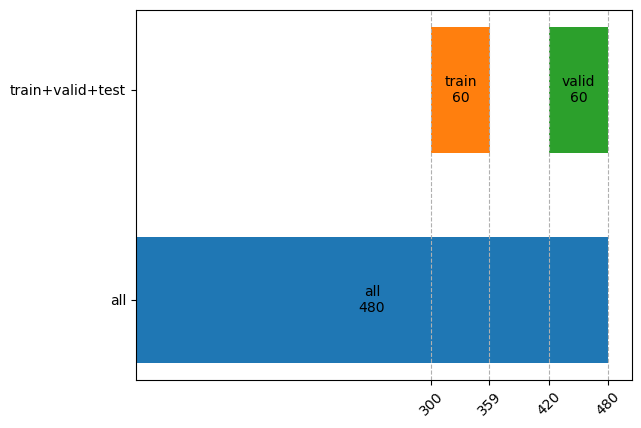

train_X.shape: (11996, 51), train_y.shape: (11996, 20)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 20)
0:	learn: 4.6079851	test: 4.6587976	best: 4.6587976 (0)	total: 417ms	remaining: 34m 46s
500:	learn: 2.5304940	test: 2.8420342	best: 2.8420342 (500)	total: 2m 59s	remaining: 26m 56s
1000:	learn: 2.2075771	test: 2.7224705	best: 2.7224705 (1000)	total: 5m 54s	remaining: 23m 37s
1500:	learn: 2.0073607	test: 2.6936543	best: 2.6936543 (1500)	total: 8m 50s	remaining: 20m 36s
2000:	learn: 1.8452482	test: 2.6799189	best: 2.6799168 (1999)	total: 11m 47s	remaining: 17m 40s
2500:	learn: 1.7047934	test: 2.6698249	best: 2.6698249 (2500)	total: 14m 43s	remaining: 14m 42s
3000:	learn: 1.5885383	test: 2.6618740	best: 2.6618070 (2998)	total: 17m 38s	remaining: 11m 45s
3500:	learn: 1.4853035	test: 2.6566742	best: 2.6566740 (3499)	total: 20m 36s	remaining: 8m 49s
4000:	learn: 1.3905761	test: 2.6527247	best: 2.6526973 (3998)	total: 23m 35s	remaining: 5m 53s
4500:	learn: 1.3048280	test: 2.6495646	be

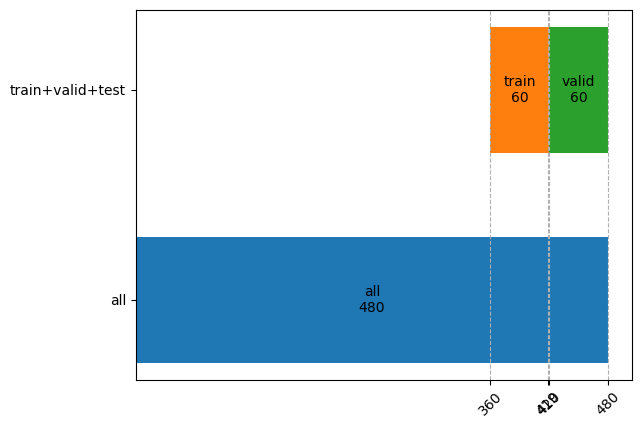

train_X.shape: (11998, 51), train_y.shape: (11998, 20)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 20)
0:	learn: 4.4355073	test: 4.6356023	best: 4.6356023 (0)	total: 319ms	remaining: 26m 35s
500:	learn: 2.4707328	test: 2.8047302	best: 2.8047302 (500)	total: 2m 58s	remaining: 26m 39s
1000:	learn: 2.1551168	test: 2.6677969	best: 2.6677969 (1000)	total: 5m 55s	remaining: 23m 38s
1500:	learn: 1.9729376	test: 2.6317427	best: 2.6317427 (1500)	total: 8m 51s	remaining: 20m 37s
2000:	learn: 1.8248474	test: 2.6117484	best: 2.6117484 (2000)	total: 11m 49s	remaining: 17m 43s
2500:	learn: 1.7030145	test: 2.5971230	best: 2.5971154 (2499)	total: 14m 44s	remaining: 14m 44s
3000:	learn: 1.5922035	test: 2.5860972	best: 2.5860972 (3000)	total: 17m 40s	remaining: 11m 46s
3500:	learn: 1.4900897	test: 2.5789933	best: 2.5789933 (3500)	total: 20m 35s	remaining: 8m 49s
4000:	learn: 1.3990900	test: 2.5739804	best: 2.5739804 (4000)	total: 23m 34s	remaining: 5m 53s
4500:	learn: 1.3133928	test: 2.5707151	be

In [7]:
params = {
    'loss_function': 'MultiRMSE',
    'eval_metric': 'MultiRMSE',
    'iterations': 5000,
    'depth': 10,
    'learning_rate': 5e-03,
    'random_state': 42,
    'bagging_temperature': 0.8,
    'random_strength': 0.8,
    #'subsample': 0.8,
    'colsample_bylevel': 0.8,
    'l2_leaf_reg': 0.0,
    'min_data_in_leaf': 20,
}

history, result_pred, result_true, fimps, mean_num_iteration = train(
    dataset=train_df,
    model_params=params,
    outputs_dir=outputs_dir_path,
)

array([[15.02191492, 28.26411416,  0.69276255, ..., 24.42665395,
         0.69280176,  6.66099591],
       [15.9271687 , 29.08187054,  0.69353961, ..., 24.1567882 ,
         0.69348688,  6.88896973],
       [13.90488414, 27.51381162,  0.69289155, ..., 24.47288382,
         0.69292128,  6.56076907],
       ...,
       [15.01963861, 28.06277383,  0.69261765, ..., 24.81198579,
         0.6926561 ,  6.92950171],
       [14.14476985, 27.39549379,  0.69350289, ..., 24.54801424,
         0.69345627,  6.73162675],
       [14.8557954 , 28.24726622,  0.69389591, ..., 24.36790482,
         0.69390033,  7.14541988]])

array([[14.65931129, 27.95919388,  0.69289547, ..., 24.38066897,
         0.69292629,  6.76580286],
       [15.78704643, 28.83078171,  0.69296092, ..., 24.84117615,
         0.69293946,  6.12757683],
       [14.24896336, 27.53375489,  0.69315898, ..., 24.11892966,
         0.69320709,  5.9993248 ],
       ...,
       [15.15768433, 28.09593927,  0.69214284, ..., 24.53974386,
         0.69219637,  7.36232042],
       [13.90631771, 27.53041876,  0.69362211, ..., 24.74303467,
         0.6935662 ,  6.33941269],
       [14.66718483, 28.59134821,  0.69427246, ..., 24.41170986,
         0.69429052,  7.12264919]])

(51, 9)


,fold1,fold2,fold3,fold4,fold5,fold6,fold7,mean_fimps,std_fimps
50_feature17,0.433641,0.366773,0.409740,0.407412,0.332721,0.315162,0.416459,0.383130,0.045439
49_feature23,0.347451,0.368026,0.444644,0.479314,0.434119,0.395158,0.370829,0.405649,0.048102
48_feature20,0.435055,0.361350,0.406480,0.531540,0.364712,0.386173,0.386366,0.410239,0.059099
47_feature36,0.485827,0.414782,0.418452,0.552776,0.447947,0.380778,0.419682,0.445749,0.057258
46_feature19,0.633477,0.721107,0.497343,0.562639,0.498463,0.415841,0.456939,0.540830,0.106384
45_feature39,0.532746,0.472446,0.540080,0.585568,0.572938,0.571183,0.546874,0.545976,0.037743
44_feature13,0.611559,0.433126,0.491675,0.612309,0.622941,0.627244,0.497888,0.556677,0.080025
43_feature25,0.441795,0.694965,0.474725,0.592737,0.521373,0.472100,0.707914,0.557944,0.109239
42_feature26,0.457832,0.714444,0.591597,0.504307,0.654892,0.547730,0.451808,0.560373,0.099374
41_feature24,0.471677,0.810884,0.561996,0.483028,0.480637,0.474752,0.796807,0.582826,0.154201


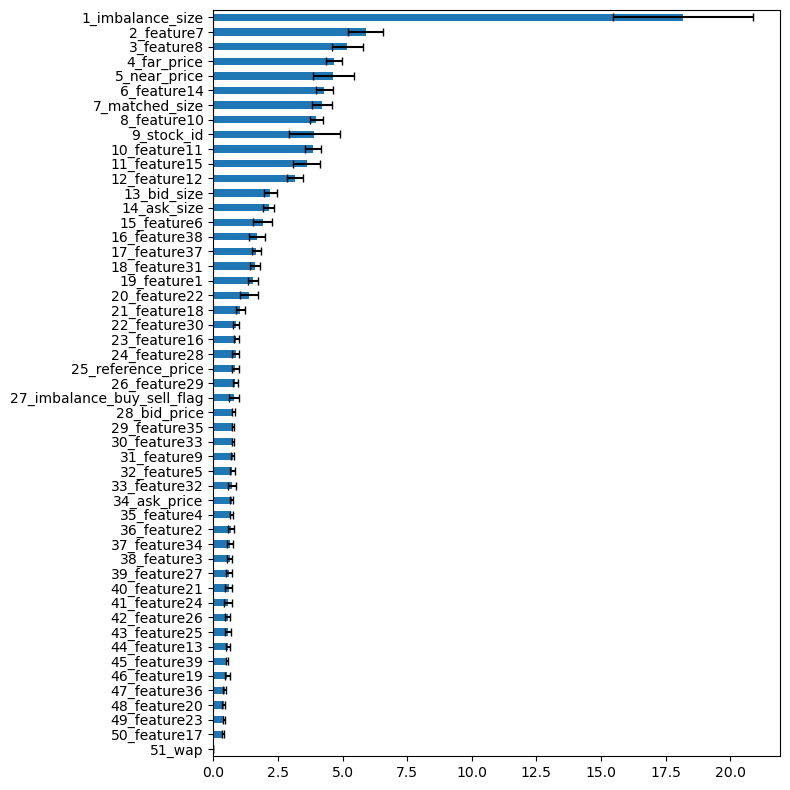

Index(['51_wap', '50_feature17', '49_feature23', '48_feature20',
       '47_feature36', '46_feature19', '45_feature39', '44_feature13',
       '43_feature25', '42_feature26'],
      dtype='object')

In [8]:
display(result_pred)
display(result_true)
print(fimps.shape)
display(fimps.tail(50))

_, ax = plt.subplots(figsize=(8, 8))
fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3, ax=ax)  
plt.tight_layout()
plt.show()

fimps_quantile_th = fimps['mean_fimps'].quantile(q=0.2)
display(fimps.query('mean_fimps < @fimps_quantile_th').index)

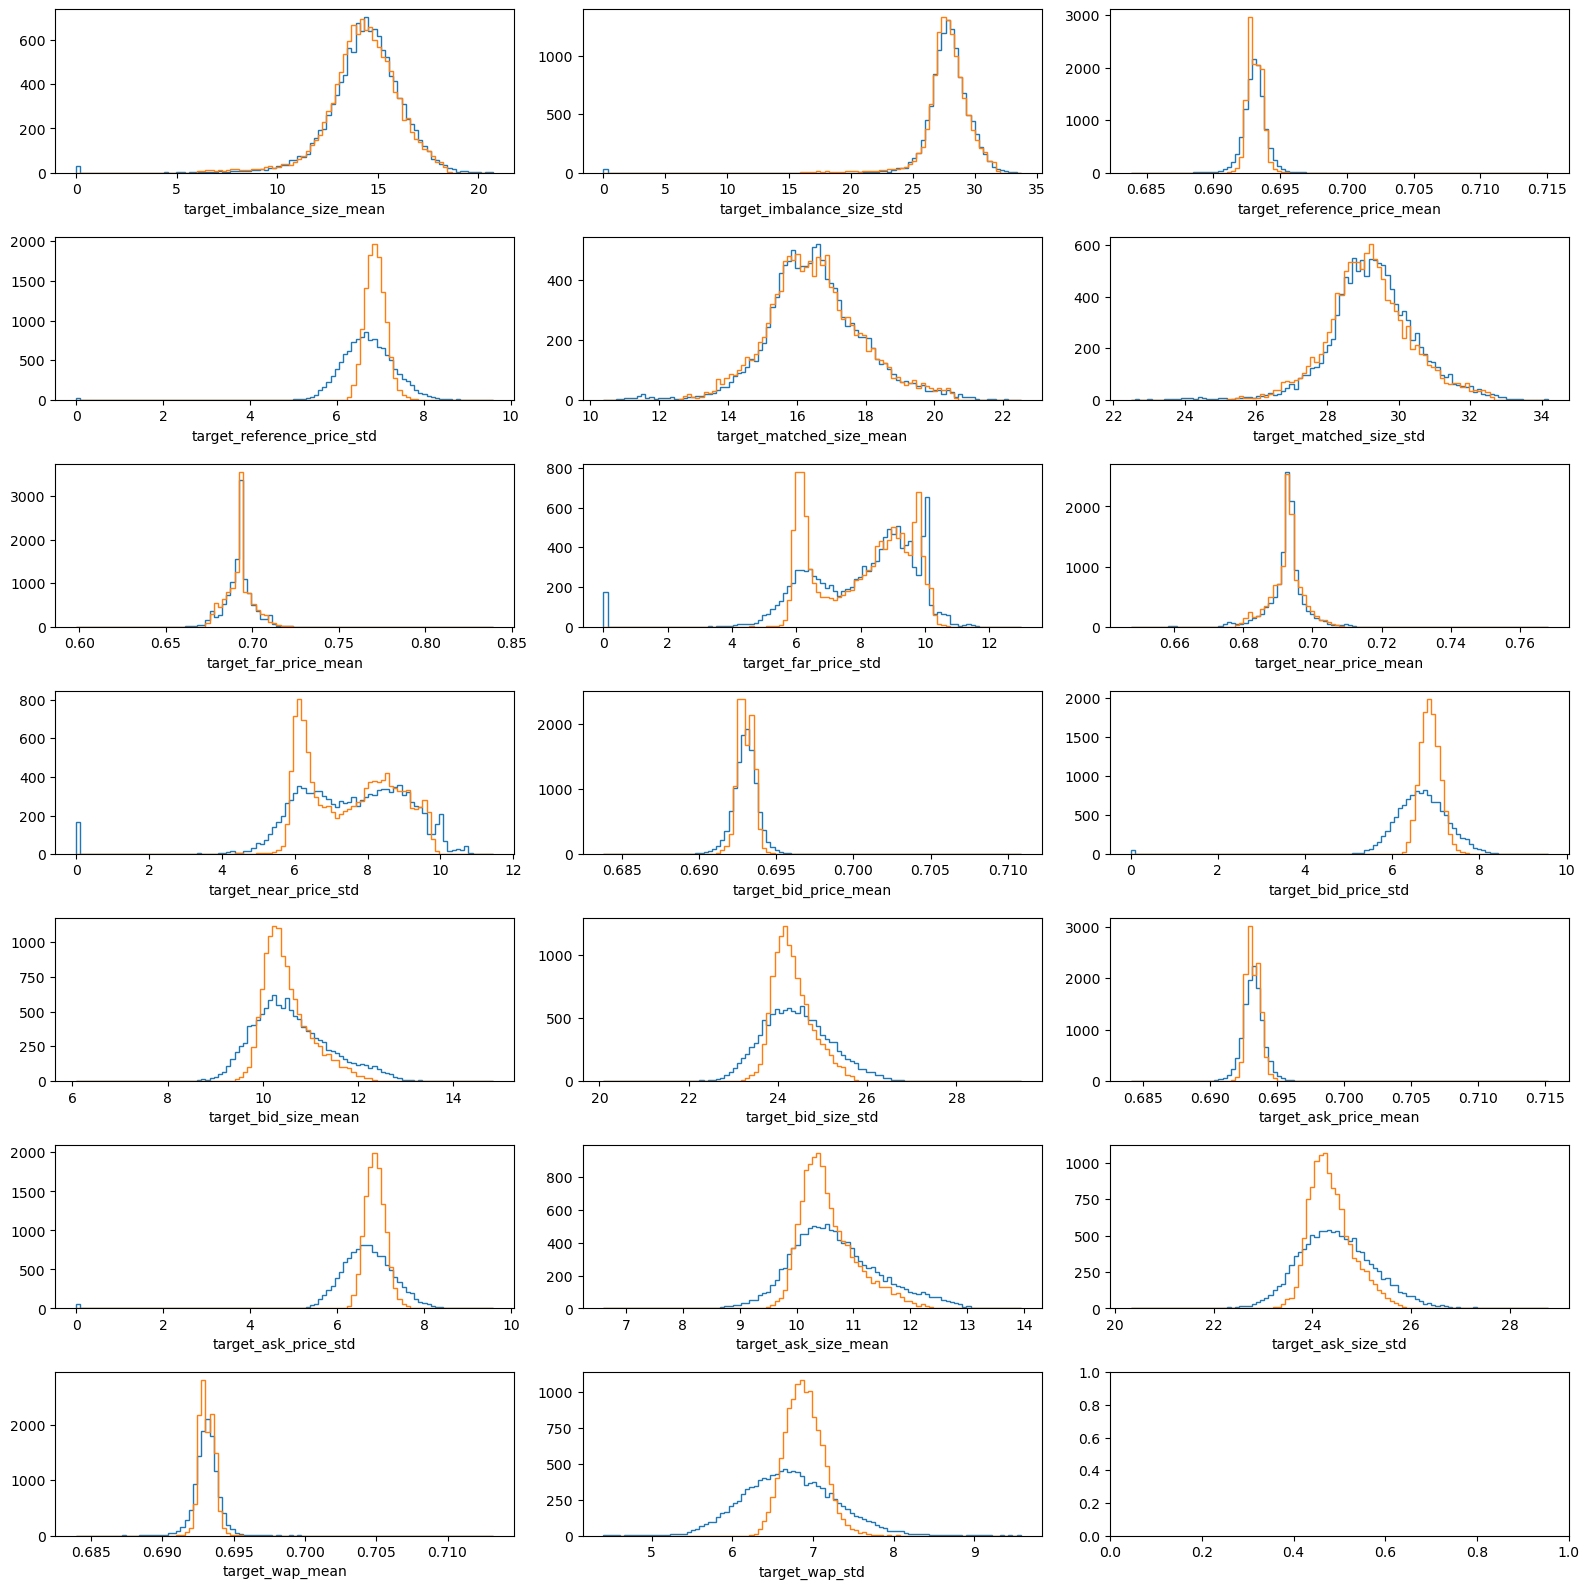

In [9]:
target_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    _, bins, _ = axs[i//3, i%3].hist(result_true[:, i], bins=100, histtype='step')
    axs[i//3, i%3].hist(result_pred[:, i], bins=bins, histtype='step')
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

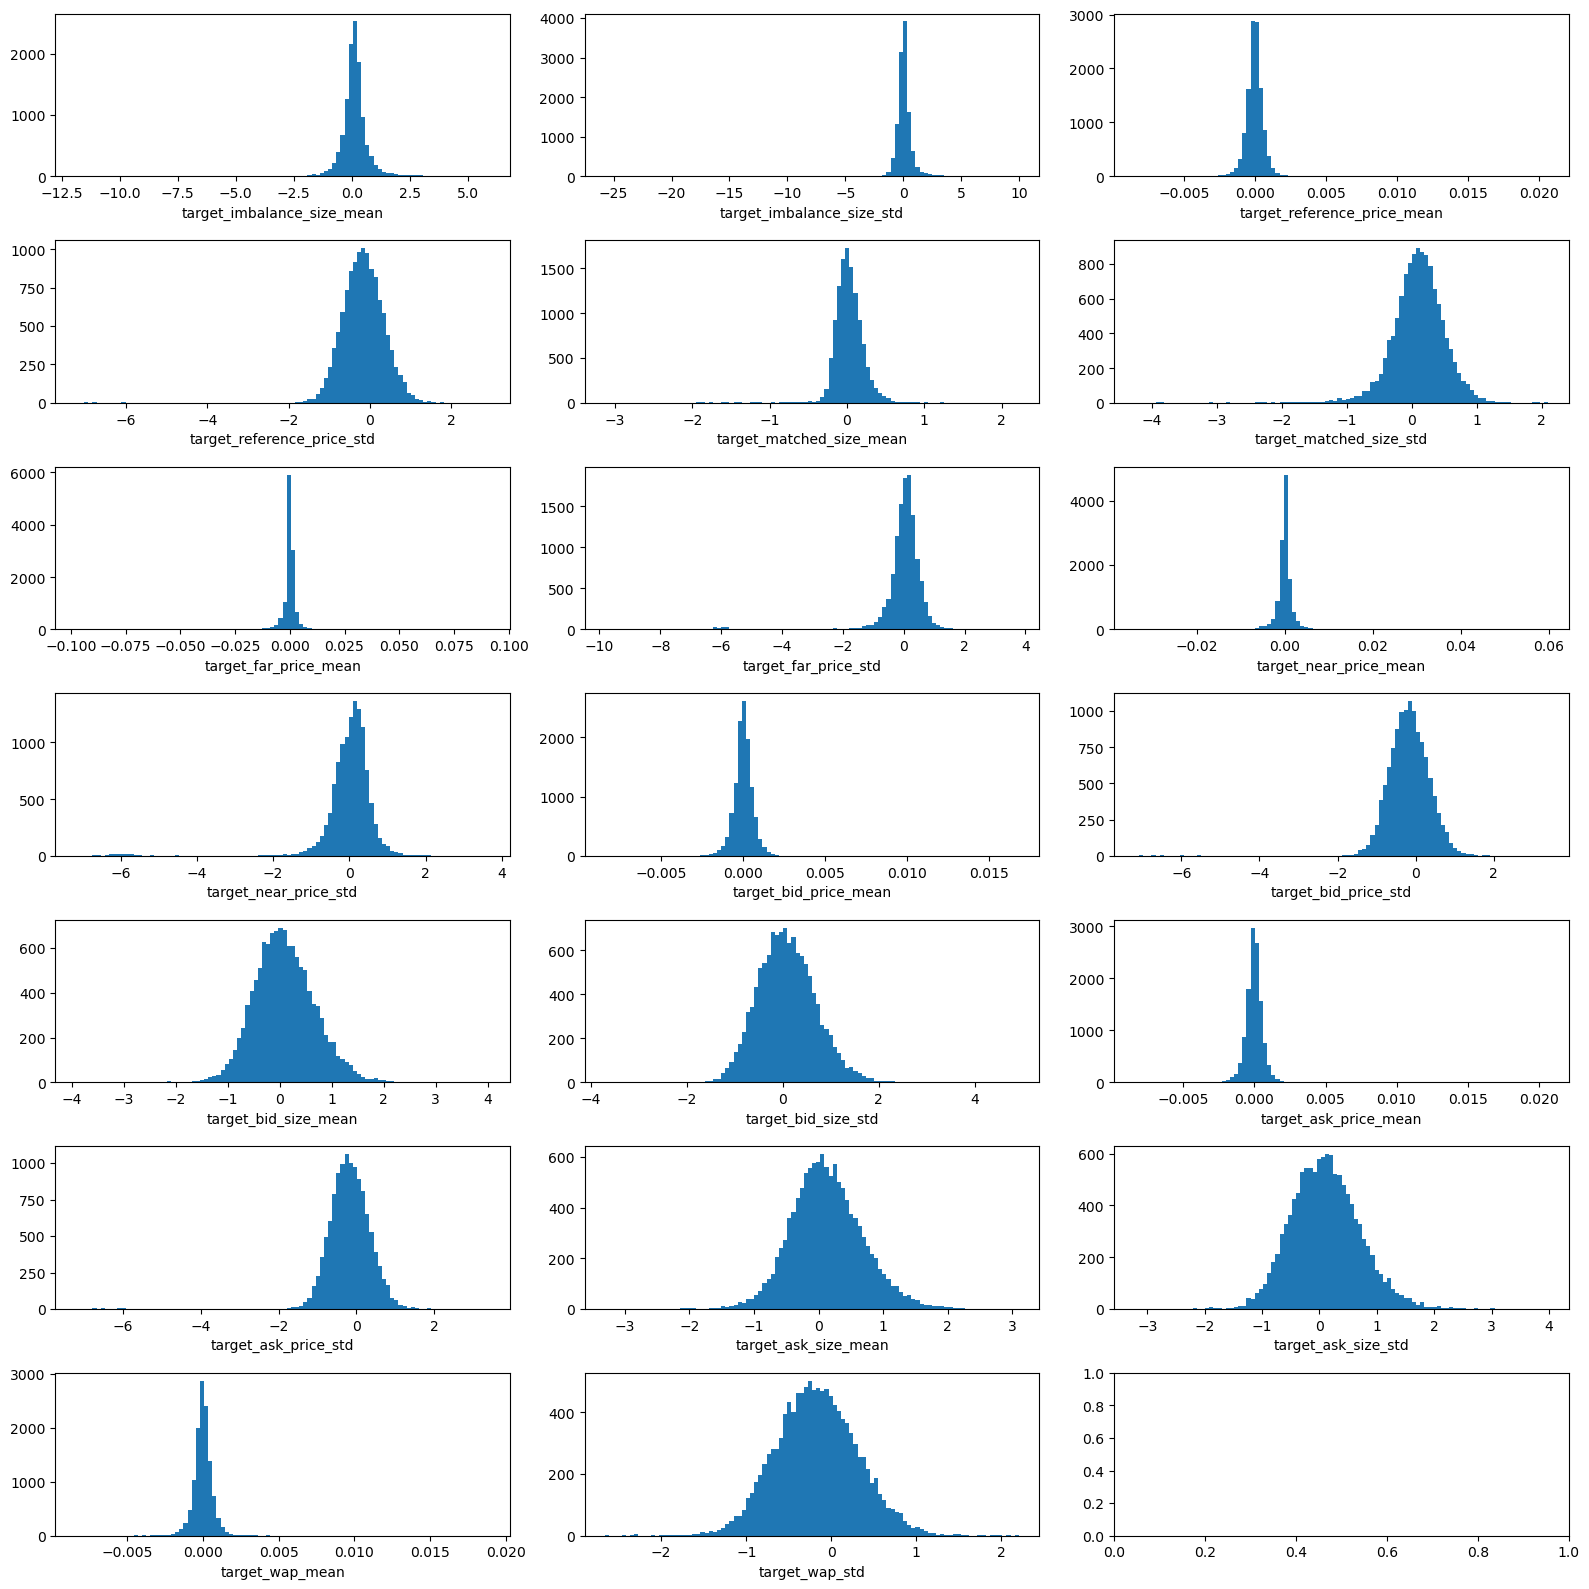

In [10]:
target_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    axs[i//3, i%3].hist(result_true[:, i]-result_pred[:, i], bins=100)
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

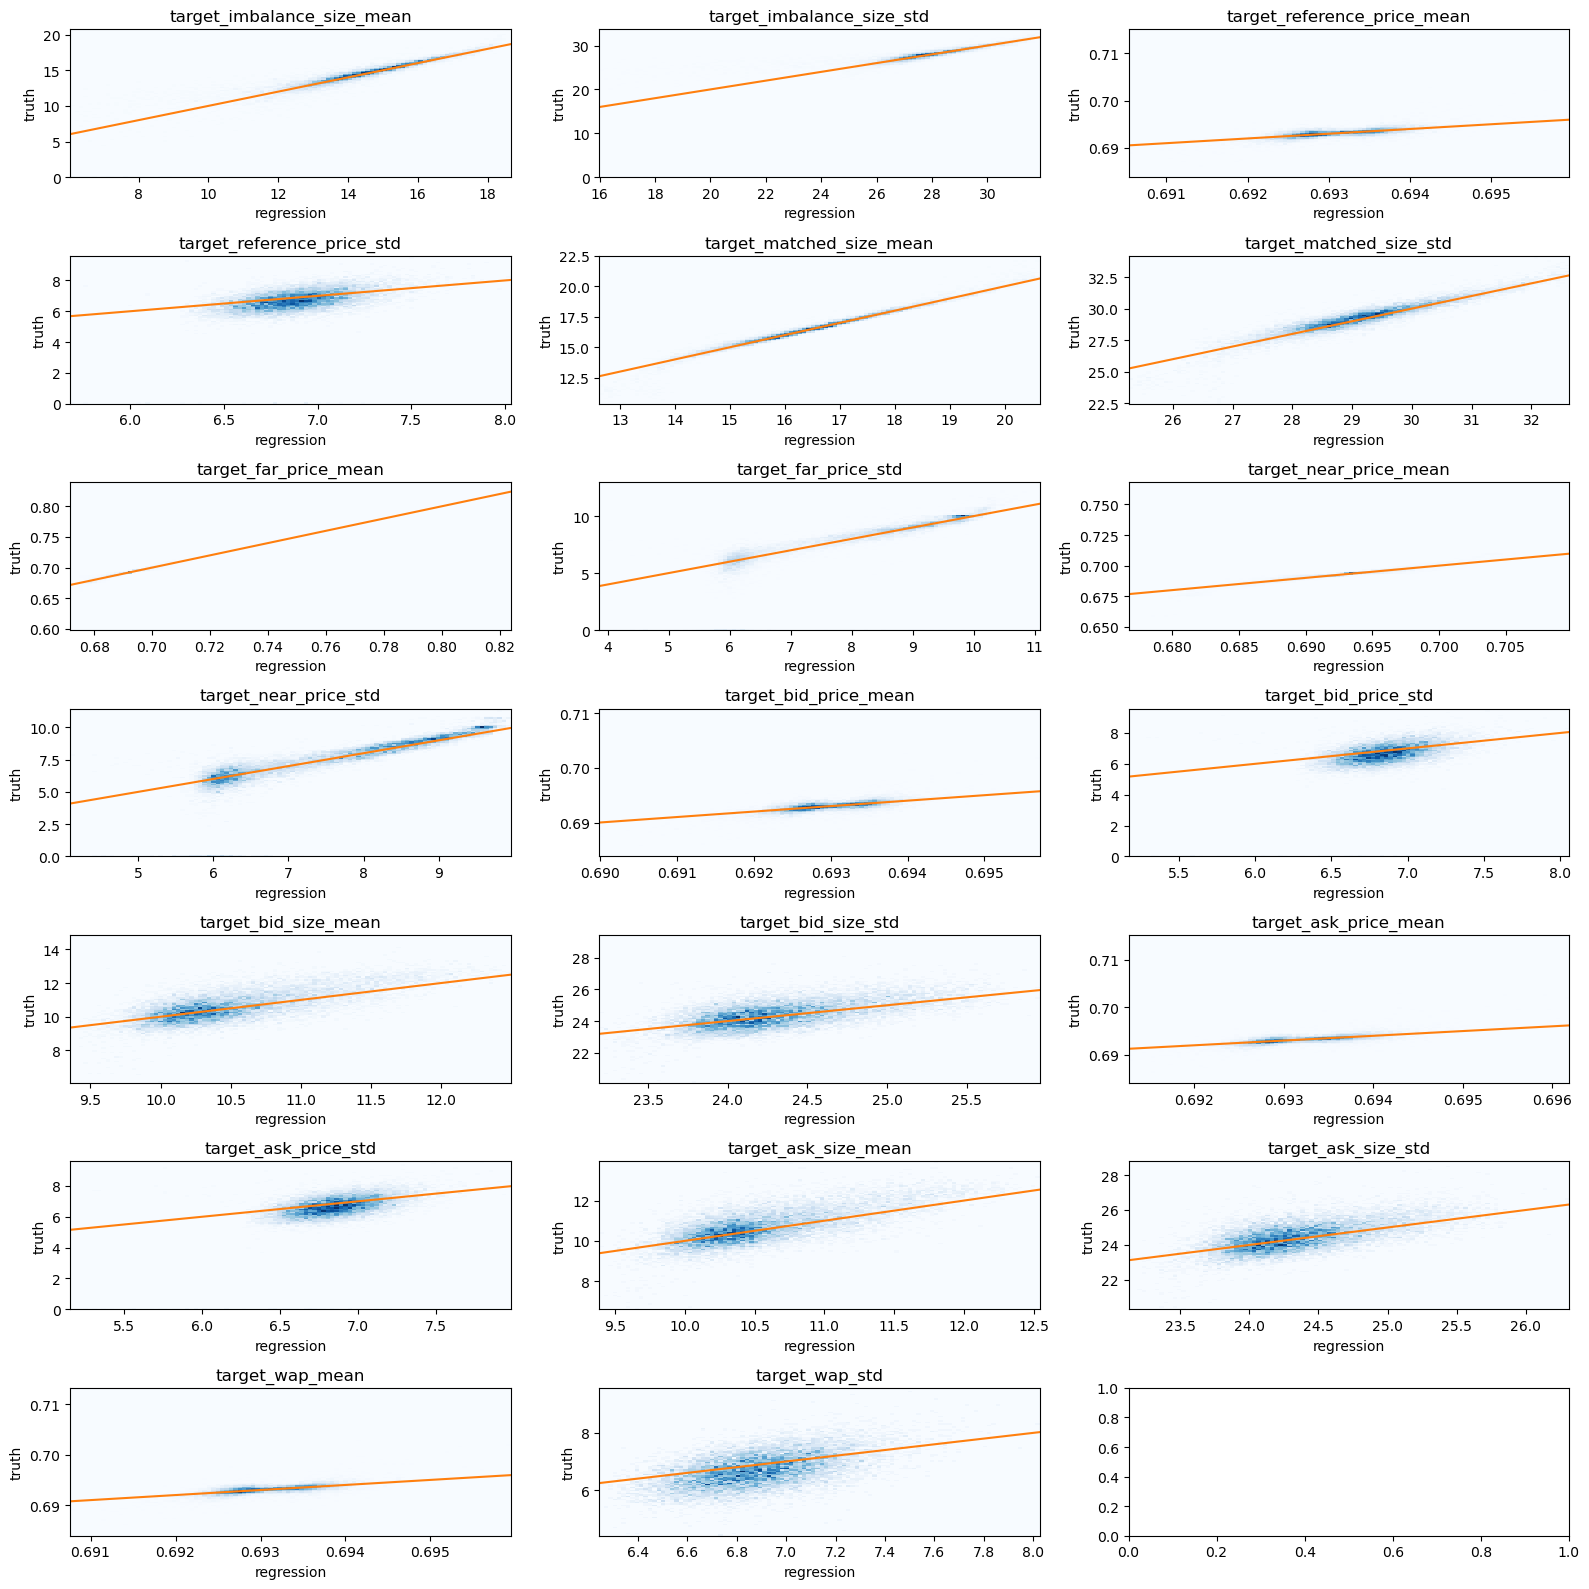

In [11]:
arget_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    axs[i//3, i%3].hist2d(result_pred[:, i], result_true[:, i], bins=100, cmap='Blues')
    axs[i//3, i%3].plot([-100, 100], [-100, 100], color='tab:orange')
    axs[i//3, i%3].set_xlabel('regression')
    axs[i//3, i%3].set_ylabel('truth')
    axs[i//3, i%3].set_title(target_columns[i])
plt.tight_layout()
plt.show()

In [12]:
target_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)

for i in range(num_targets):
   r = np.corrcoef(result_true[:, i], result_pred[:, i])
   print(f'{target_columns[i]}: {r[0, 1]:.4f}')

target_imbalance_size_mean: 0.9199
target_imbalance_size_std: 0.7751
target_reference_price_mean: 0.6904
target_reference_price_std: 0.5048
target_matched_size_mean: 0.9851
target_matched_size_std: 0.9404
target_far_price_mean: 0.8859
target_far_price_std: 0.8764
target_near_price_mean: 0.9256
target_near_price_std: 0.8658
target_bid_price_mean: 0.6825
target_bid_price_std: 0.4828
target_bid_size_mean: 0.7191
target_bid_size_std: 0.6219
target_ask_price_mean: 0.6797
target_ask_price_std: 0.4863
target_ask_size_mean: 0.7160
target_ask_size_std: 0.6240
target_wap_mean: 0.6744
target_wap_std: 0.5335


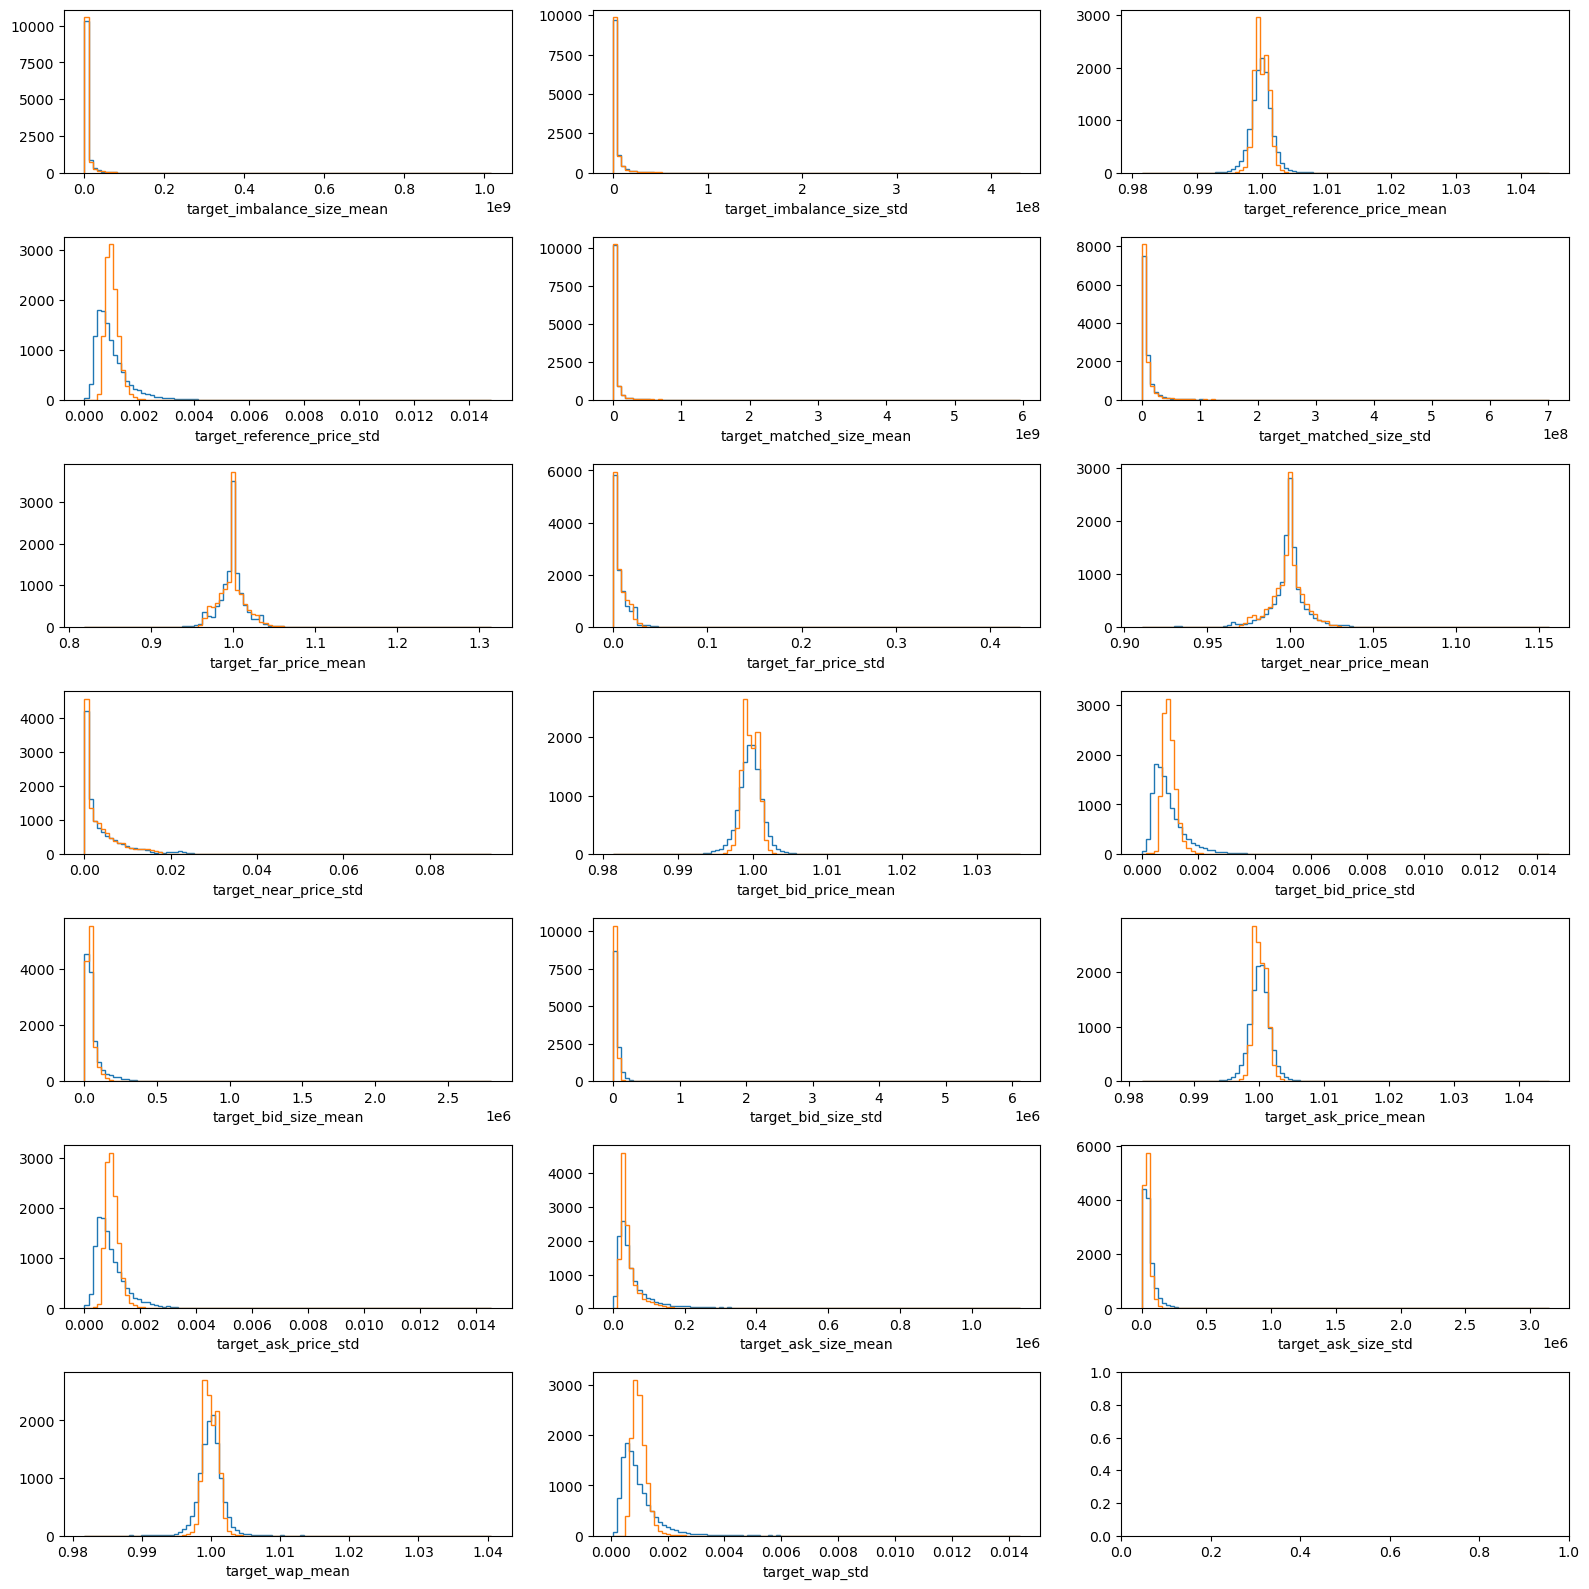

In [13]:
target_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    true = np.exp(result_true[:, i]) - 1
    reg = np.exp(result_pred[:, i]) - 1
    if 'std' in target_columns[i]:
        true /= 1e+06
        reg /= 1e+06
    _, bins, _ = axs[i//3, i%3].hist(true, bins=100, histtype='step')
    axs[i//3, i%3].hist(reg, bins=bins, histtype='step')
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

## train catboost model using all data

In [14]:
target_columns = [col for col in train_df.columns if 'target' in col]
print(target_columns)
feature_columns = [col for col in train_df.columns if col not in target_columns and col != 'date_id']


train_pool = Pool(
    data=train_df[feature_columns],
    label=train_df[target_columns],
)

del train_df
gc.collect()

params['iterations'] = mean_num_iteration

model = CatBoostRegressor(**params)
model.fit(
    X=train_pool,
    use_best_model=True,
    verbose=500,
)
model.save_model(
    outputs_dir_path.joinpath(f'catboost_trained_using_alldata_predict_statistics.txt'),
)

['target_imbalance_size_mean', 'target_imbalance_size_std', 'target_reference_price_mean', 'target_reference_price_std', 'target_matched_size_mean', 'target_matched_size_std', 'target_far_price_mean', 'target_far_price_std', 'target_near_price_mean', 'target_near_price_std', 'target_bid_price_mean', 'target_bid_price_std', 'target_bid_size_mean', 'target_bid_size_std', 'target_ask_price_mean', 'target_ask_price_std', 'target_ask_size_mean', 'target_ask_size_std', 'target_wap_mean', 'target_wap_std']


You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 4.9815353	total: 398ms	remaining: 25m 52s
500:	learn: 3.0557459	total: 3m 26s	remaining: 23m 19s
1000:	learn: 2.9056031	total: 6m 50s	remaining: 19m 51s
1500:	learn: 2.8318815	total: 10m 18s	remaining: 16m 29s
2000:	learn: 2.7715573	total: 13m 44s	remaining: 13m 4s
2500:	learn: 2.7117936	total: 17m 9s	remaining: 9m 37s
3000:	learn: 2.6462044	total: 20m 35s	remaining: 6m 11s
3500:	learn: 2.5842865	total: 24m	remaining: 2m 45s
3902:	learn: 2.5376334	total: 26m 49s	remaining: 0us
